### Imports

In [2]:
# Remove future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary classification specific metrics
from sklearn.metrics import roc_curve

# General metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Management

In [3]:
df = pd.read_csv('data/BTC-USD.csv')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,MA_12,MA_21,DOW,Rolling_Rets,Average_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-31 00:00:00+00:00,-0.106007,-0.081859,-0.025785,10221.099609,-0.069080,0.011359,0.061793,-0.245160,33.630608,1.034591,11245.008464,11906.661970,2,-0.225821,0.111267,-0.105352,0.126642,0.836912,-0.041565,0.062294,0.925513
2018-02-01 00:00:00+00:00,0.012772,-0.008939,-0.098711,9170.540039,0.238553,-0.102783,0.167552,-0.324832,28.887695,0.858970,10934.286784,11704.982933,3,-0.425615,0.111076,0.011359,0.061793,1.034591,-0.105352,0.126642,0.836912
2018-02-02 00:00:00+00:00,-0.106964,-0.111434,-0.115270,8830.750000,0.277878,-0.037052,0.172615,-0.348275,27.535088,0.953177,10703.507650,11459.752000,4,-0.477278,0.115194,-0.102783,0.167552,0.858970,0.011359,0.061793,1.034591
2018-02-03 00:00:00+00:00,-0.031738,0.031553,0.058378,9174.910156,-0.429257,0.038973,0.142895,-0.322817,31.056267,1.127880,10557.133464,11212.833426,5,-0.464501,0.117163,-0.037052,0.172615,0.953177,-0.102783,0.167552,0.858970
2018-02-04 00:00:00+00:00,0.036554,-0.010167,-0.026711,8277.009766,-0.026190,-0.097865,0.162323,-0.389567,27.325632,0.879875,10341.184245,10951.167225,6,-0.679699,0.117087,0.038973,0.142895,1.127880,-0.037052,0.172615,0.953177


In [4]:
# Specify target
df.loc[df.Range.shift(-1) > df.Average_Range, 'target'] = 1
df.loc[df.Range.shift(-1) <= df.Average_Range, 'target'] = 0

In [5]:
# Check for NaN values
nan_location = np.where(np.isnan(df))
nan_location

# Fill NaN values
df['target'].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,MA_12,MA_21,DOW,Rolling_Rets,Average_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,target
Date,,,,,,,,,,,,,,,,,,,,,,
2023-12-26 00:00:00+00:00,0.013701,-0.003700,-0.025471,42520.402344,0.422009,-0.025055,0.046230,2.412708,53.309827,0.889748,42903.092773,42959.870350,1,0.134243,0.034245,0.013879,0.023367,1.046988,-0.016539,0.027078,0.924521,1.0
2023-12-27 00:00:00+00:00,-0.024802,0.001834,0.011783,43442.855469,-0.158722,0.021694,0.035942,2.488779,57.563288,1.079788,43029.184245,42945.413690,2,0.161940,0.034709,-0.025055,0.046230,0.889748,0.013879,0.023367,1.046988,1.0
2023-12-28 00:00:00+00:00,0.022337,0.002784,0.003580,42627.855469,-0.089816,-0.018760,0.035120,2.422268,52.971739,0.920235,43061.495768,42913.756138,3,0.127693,0.034545,0.021694,0.035942,1.079788,-0.025055,0.046230,0.889748,1.0
2023-12-29 00:00:00+00:00,-0.019636,-0.015534,-0.021137,42099.402344,0.130824,-0.012397,0.041045,2.379228,50.176936,0.947240,43122.723958,42815.318080,4,0.114572,0.035245,-0.018760,0.035120,0.920235,0.021694,0.035942,1.079788,0.0
2023-12-30 00:00:00+00:00,-0.012270,-0.012527,0.003191,42156.902344,-0.384080,0.001366,0.024735,2.383458,50.483066,1.006101,43083.837565,42740.599888,5,0.119787,0.035528,-0.012397,0.041045,0.947240,-0.018760,0.035120,0.920235,0.0


### Train-Test Split

In [6]:
df_tts = df.copy()
df_tts = df_tts[['DOW', 'Range', 'RSI', 'RSI_Ret_T1', 'target']]

In [7]:
# Split into X and y
X = df_tts.iloc[:, :-1]
y = df_tts.iloc[:, -1]

In [8]:
# Perform train-test split (time-series based method)
train_size_ratio = 0.7
train_size = int(len(X) * train_size_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1512, 4)
X_test shape: (648, 4)
y_train shape: (1512,)
y_test shape: (648,)


### Build Model

In [10]:
# Select a type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [11]:
# Determine objective and evaluation metric
if is_binary:
    objective = 'binary:logistic'
    eval_metric = 'logloss'
    eval_metric_list = ['error', 'logloss', eval_metric]
else:
    objective = 'multi:softmax'
    eval_metric = 'mlogloss'
    eval_metric_list = ['merror', 'mlogloss', eval_metric]

In [12]:
# Refine evaluation metric
if is_binary and is_optimise_for_precision:
    eval_metric = 'aucpr'
    scoring = 'precision'
elif is_binary and not is_optimise_for_precision:
    eval_metric = 'auc'
    scoring = 'f1'
else:
    scoring = 'accuracy'

In [13]:
# Best hyperparameters: n_estimators=100, max_depth=3, learning_rate=0.01, gamma=1
ne = 100
md = 3
lr = 0.01
gm = 1

In [15]:
# Build classifier
classifier = XGBClassifier(
    objective=objective, 
    booster='gbtree', 
    eval_metric=eval_metric, 
    ne_estimators=ne,
    max_depth=md,
    learning_rate=lr,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [27]:
# Fit model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              ne_estimators=100, num_parallel_tree=None, ...)

### Make Predictions

In [28]:
# Get predictions for training
train_yhat = classifier.predict(X_train)
train_yhat_prob = classifier.predict_proba(X_train)

print(f"Training accuracy: {accuracy_score(y_train, train_yhat)}")
print(f"Training precision: {precision_score(y_train, train_yhat)}")
print(f"Training confusion matrix:\n{confusion_matrix(y_train, train_yhat)}")

Training accuracy: 0.7037037037037037
Training precision: 0.8583333333333333
Training confusion matrix:
[[961  17]
 [431 103]]


In [29]:
print(train_yhat_prob[:5])

[[0.50659126 0.49340874]
 [0.42020023 0.5797998 ]
 [0.43048882 0.5695112 ]
 [0.43614113 0.56385887]
 [0.44786876 0.55213124]]


In [30]:
# Get predictions for test
test_yhat = classifier.predict(X_test)
test_yhat_prob = classifier.predict_proba(X_test)

print(f"Test accuracy: {accuracy_score(y_test, test_yhat)}")
print(f"Test precision: {precision_score(y_test, test_yhat)}")
print(f"Test confusion matrix:\n{confusion_matrix(y_test, test_yhat)}")

Test accuracy: 0.6435185185185185
Test precision: 0.6078431372549019
Test confusion matrix:
[[386  20]
 [211  31]]


In [31]:
# Set K-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [32]:
# Training results
train_results = cross_val_score(classifier, X_train, y_train, cv=cv, scoring=scoring)

### Evaluation Metrics - Loss and Overfitting

In [33]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results['validation_0'][eval_metric])
x_axis = range(0, epochs)

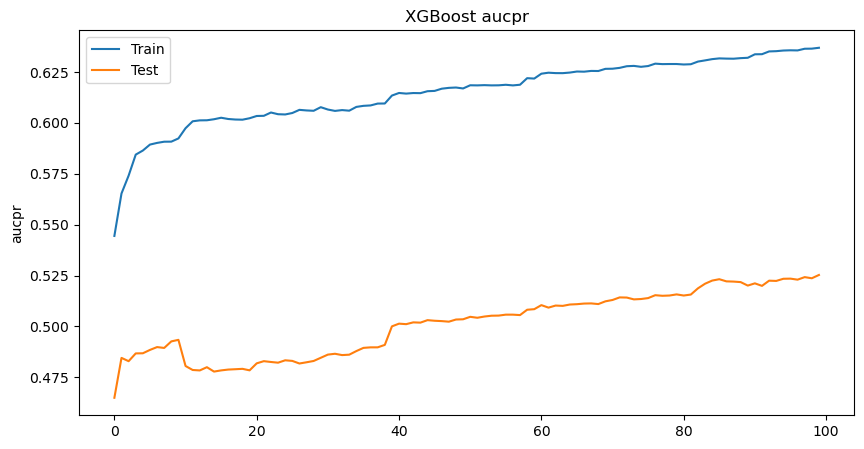

In [34]:
# Plot log loss
fig = plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0'][eval_metric], label='Train')
plt.plot(x_axis, results['validation_1'][eval_metric], label='Test')
plt.legend()
plt.ylabel(f"{eval_metric}")
plt.title(f"XGBoost {eval_metric}")
plt.show()

### Performance Evaluation Comparison

In [35]:
# Set K-Fold cross-validation levels
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [36]:
# Training results
train_results = cross_val_score(classifier, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, cv=cv, scoring=scoring, n_jobs=-1)

In [38]:
# Comparison of results
print("Train: ")
print(f"Mean: {train_results.mean()}")
print(f"Standard deviation: {train_results.std()}")
print("Precision score: ", precision_score(y_test, test_yhat))
print("Test: ")
print(f"Mean: {test_results.mean()}")
print(f"Standard deviation: {test_results.std()}")
print("Precision score: ", precision_score(y_test, test_yhat))

Train: 
Mean: 0.7208577828546868
Standard deviation: 0.13863400741070514
Precision score:  0.6078431372549019
Test: 
Mean: 0.510978835978836
Standard deviation: 0.23565193297594467
Precision score:  0.6078431372549019


### Evaluation Metrics - Summary Report

In [39]:
# Show summary report - training 
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81       978
         1.0       0.86      0.19      0.31       534

    accuracy                           0.70      1512
   macro avg       0.77      0.59      0.56      1512
weighted avg       0.75      0.70      0.64      1512



In [40]:
# Show summary report - test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.65      0.95      0.77       406
         1.0       0.61      0.13      0.21       242

    accuracy                           0.64       648
   macro avg       0.63      0.54      0.49       648
weighted avg       0.63      0.64      0.56       648



### Performance Evaluation - Confusion Matrix

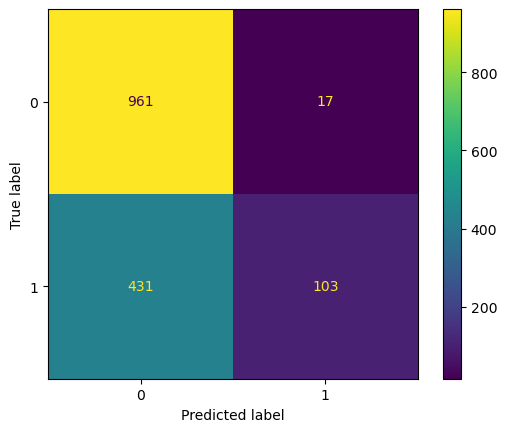

In [44]:
# Training confusion matrix
cm = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_).plot()

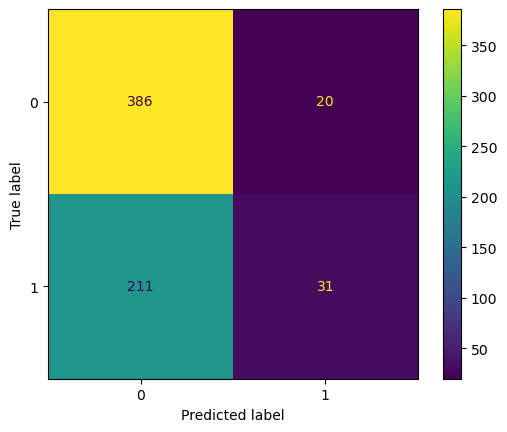

In [45]:
# Test confusion matrix
cm = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_).plot()

### Feature Importance

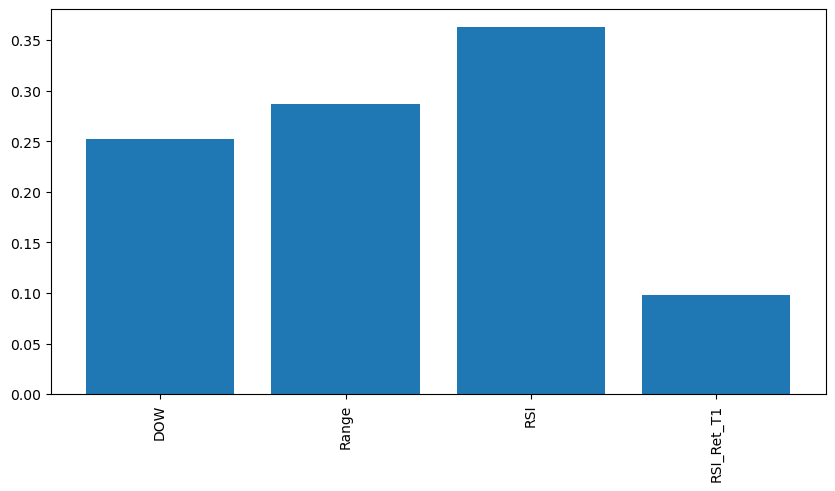

In [49]:
# Plot feature importances
fig = plt.figure(figsize=(10, 5))
importance_labels = X.columns
importance_values = classifier.feature_importances_
plt.bar([x for x in range(len(importance_values))], importance_values)
plt.xticks(ticks=[x for x in range(len(importance_values))], labels=importance_labels, rotation=90)
plt.show()